In [5]:
!pip install joblib
!pip install numpy
!pip install scipy
!conda update scikit-learn

!pip install -U scikit-learn



PackageNotInstalledError: Package is not installed in prefix.
  prefix: /home/peng/anaconda2
  package name: scikit-learn




In [210]:
# machine learning

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict,cross_validate, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic, WhiteKernel, Matern
from sklearn.neural_network import MLPRegressor
from sklearn import datasets
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RandomizedLasso, Lasso
import joblib

#pandas
import pandas as pd
import math
from math import sqrt
from pandas import Series,DataFrame
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from time import time
from enum import Enum

import warnings
warnings.filterwarnings('ignore')

def adj_r2_score(p,y,yhat):
    """Adjusted R square — put fitted linear model, y value, estimated y value in order"""
    adj = 1 - float(len(y)-1)/(len(y)-p-1)*(1 - r2_score(y,yhat))
    return adj


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

class predictY(Enum):
    CATALOGUE = 1
    CART = 2
    WEB = 3
    SHIPPING = 4

class X(Enum):
    PODCPU = 1
    PODCPU_VMCPU = 2
    PODCPU_VMCPI = 3

import matplotlib.pylab as pylab
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['pdf.fonttype'] = 42
params = {'legend.fontsize': 'x-large',
         'figure.figsize': (4, 3),
         #'font.family': 'serif',
         'font.sans-serif': 'Arial', 
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         #'axes.labelweight':'bold', 
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

latency_metrics = ["ratings_95th_latency", "cart_95th_latency",  "user_95th_latency",
                  "payment_95th_latency", "catalogue_95th_latency", "ratings_95th_latency",
                  "shipping_95th_latency", "web_95th_latency", "mysql_95th_latency",
                 "mongodb_95th_latency", "dispatch_95th_latency", "redis_95th_latency",
                 "rabbitmq_95th_latency",
                  ]


In [233]:
hidden_layer_sizes=(5,3, 3)

def TrainingByDifferentModel(dfnorm, y, name):
    svr = svm.SVR(kernel='linear')
    lr = LinearRegression()
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=0.5)
    #kernel = 0.5**2 * RationalQuadratic(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    #kernel = 0.75**2 * RationalQuadratic(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    kernel =  1**2 * RBF(length_scale=50.0) + 1**2 * RationalQuadratic(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

    nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=hidden_layer_sizes, random_state=1, max_iter=1000, activation='relu',learning_rate_init='0.01',momentum=0.9)
    cv = 3
    n_jobs=3
    predicted_lr = cross_val_predict(lr, dfnorm, y, cv=cv, n_jobs=n_jobs,)
    predicted_svr = cross_val_predict(svr, dfnorm, y, n_jobs=n_jobs,cv=cv)
    predicted_dt = cross_val_predict(dt, dfnorm, y, n_jobs=n_jobs,cv=cv)
    predicted_rf = cross_val_predict(rf, dfnorm, y, n_jobs=n_jobs,cv=cv)
    predicted_gp = cross_val_predict(gp, dfnorm, y,n_jobs=n_jobs, cv=cv)
    predicted_nn = cross_val_predict(nn, dfnorm, y, n_jobs=n_jobs,cv=cv)

    result = cross_validate(gp, dfnorm, y,n_jobs=n_jobs, cv=cv, return_estimator=True)
    for i, score in enumerate(result["test_score"]):
        if score == max(result["test_score"]):
            gp = result["estimator"][i]
        
    
    print(gp)
    #print(gp)
    #gp.fit(dfnorm, y)
    #print(gp)
    # do not run until the previous step finishes execution. gaussian process and neural network cross validation takes some time.
    joblib.dump(gp, 'models/gp_{}.model'.format(name))

    print("\tLR\tSVR\tDT\tRF\tNN\tGP")
    cv_lr = mean_absolute_error(y, predicted_lr)
    cv_svr = mean_absolute_error(y, predicted_svr)
    cv_dt = mean_absolute_error(y, predicted_dt)
    cv_rf = mean_absolute_error(y, predicted_rf)
    cv_nn = mean_absolute_error(y, predicted_nn)
    cv_gp = mean_absolute_error(y, predicted_gp)
    
    print("mae\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (cv_lr, cv_svr, cv_dt, cv_rf, cv_nn, cv_gp))
    cv_lr = mean_absolute_percentage_error(y, predicted_lr)
    cv_svr = mean_absolute_percentage_error(y, predicted_svr)
    cv_dt = mean_absolute_percentage_error(y, predicted_dt)
    cv_rf = mean_absolute_percentage_error(y, predicted_rf)
    cv_nn = mean_absolute_percentage_error(y, predicted_nn)
    cv_gp = mean_absolute_percentage_error(y, predicted_gp)

    print("mape\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (cv_lr, cv_svr, cv_dt, cv_rf, cv_nn, cv_gp))

    cv_lr = sqrt(mean_squared_error(y, predicted_lr))
    cv_svr = sqrt(mean_squared_error(y, predicted_svr))
    cv_dt = sqrt(mean_squared_error(y, predicted_dt))
    cv_rf = sqrt(mean_squared_error(y, predicted_rf))
    cv_nn = sqrt(mean_squared_error(y, predicted_nn))
    cv_gp = sqrt(mean_squared_error(y, predicted_gp))
    #cv_gp = 0

    print("rmse\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (cv_lr, cv_svr, cv_dt, cv_rf, cv_nn, cv_gp))


    print("r2\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (r2_score(y, predicted_lr), r2_score(y, predicted_svr), r2_score(y, predicted_dt), r2_score(y, predicted_rf), r2_score(y, predicted_nn), r2_score(y, predicted_gp)))
    #print("r2\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (adj_r2_score(p, y, predicted_lr), r2_score(y, predicted_svr), r2_score(y, predicted_dt), r2_score(y, predicted_rf), r2_score(y, predicted_nn)))
    
    fig, ax = plt.subplots()
    #plt.title('Cross-validated predictions of 95th percentile latency (ms)')
    ax.scatter(y, predicted_gp, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured tail latency (ms)')
    ax.set_ylabel('Predicted tail latency (ms)')
    #ax.set_xlim(50,500)
    #ax.set_ylim(50,500)
    plt.grid(True)
    #plt.xticks(np.arange(0, 501, step=100))
    #plt.yticks(np.arange(0, 501, step=100))
    plt.tight_layout()
    plt.show()
    return 
    fig, ax = plt.subplots()
    #plt.title('Cross-validated predictions of 95th percentile latency (ms)')
    ax.scatter(y, predicted_nn, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured tail latency (ms)')
    ax.set_ylabel('Predicted tail latency (ms)')
    #ax.set_xlim(50,500)
    #ax.set_ylim(50,500)
    plt.grid(True)
    #plt.xticks(np.arange(0, 501, step=100))
    #plt.yticks(np.arange(0, 501, step=100))
    plt.tight_layout()
    plt.show()


In [234]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression

# feature selection
def FeatureSelection(rdf, y, name, alpha=0.1):             
    #feature importance
    rlasso = Lasso(alpha=alpha)
    rlasso.fit(rdf, y)
    print("rlasso ", rlasso.coef_.tolist())
    print("rlasso ", rlasso.intercept_.tolist())
    ret = []
    column = rdf.columns.tolist()
    for i in range(len(rlasso.coef_)):
        if abs(rlasso.coef_[i]) >= 0.05:
            ret.append(column[i])
    
    print("feature selection length is ", len(ret), ret)
    with open("models/selected_feature_{}.txt".format(name), "w") as outfile:
        outfile.write("\n".join(ret))
    
    data = [line.strip() for line in open("models/selected_feature_{}.txt".format(name), 'r')]    
    return ret

In [235]:
!git pull
# check collected data
# 1. more workload, more tail latency
# 2. more workload, more cpu usage

rdf_all = pd.read_csv('../training_data/bigtable.csv')

latency1_metrics = ["ratings_95th_latency", "cart_95th_latency",  "user_95th_latency", "catalogue_95th_latency",
                  "shipping_95th_latency", "web_95th_latency",
                  ]
pod_list = ["ratings", "cart",  "user","payment", "catalogue", "shipping", "web", "mysql","mongodb", "dispatch", "redis","rabbitmq",]

no_metrics = []
for name in ["_perf_cpi","_perf_llc", "_cont_netW5s_avg", "_cont_netR5s_avg", "_vm_netW", "_vm_netR", 
            "_cont_memW5s_avg", "_cont_memR5s_avg", ]:
    no_metrics += [ pod + name for pod in pod_list] 

    
hidden_layer_sizes=(5,3, 3)
def rdf_filter(rdf):
    
    # outlier removal
    rdf = rdf[rdf.test_id.str.contains('Jun30')]
    #rdf = rdf[~rdf.test_id.str.contains('Jun02')]
    #rdf = rdf[~rdf.test_id.str.contains('May')]
    #rdf = rdf[rdf.test_id.str.contains('.*_10|20_*')]
    #rdf = rdf[rdf.test_id.str.contains('none_2113312')]
    #rdf = rdf[rdf.test_id.str.contains('blue')]
    #rdf = rdf[rdf.test_id.str.contains('none')]
    print(rdf.shape)
    new = rdf["test_id"].str.split("_", n = 4, expand = True)
    new_name = new[2]+"_"+new[3]+"_"+new[4]
    new_name = new[3]+"_"+new[4]
    new_name = set(new_name.tolist())
    rdf['thread'] = new[2]
    pd.set_option('max_columns', None)
    new_rdf = pd.DataFrame(columns=rdf.columns.tolist())
    
    for name in [ pod + "_workload_fail" for pod in pod_list]:
        #rdf = rdf[rdf[name]==0]
        pass
    print(rdf.shape)
    for i, name in enumerate(new_name):
        for color in ["red", "blue", "green", "yellow"]:
            tmp_result = rdf[rdf.test_id.str.contains(name)][rdf.test_id.str.contains(color)].sort_values(by=['thread'])
            #[cpu_metrics+latency1_metrics]
            print(tmp_result.shape)
            if tmp_result.shape[0] > 0:
                print(tmp_result.drop(no_metrics, axis=1))
                print("\n")
        tmp_rdf = rdf[rdf.test_id.str.contains(name)].mean().to_frame().T
        new_rdf = new_rdf.append(tmp_rdf, ignore_index=True)
        #print(tmp_rdf)

    #print(new_name)
    rdf = new_rdf
    rdf = rdf.drop(columns=['test_id'])
    rdf['thread'] = new[2]
    rdf = rdf.sort_values(by=['thread'])
    rdf = rdf.fillna(0)
    rdf = rdf.dropna()
    #subset=filter_metrics)
    return rdf



rdf_all = rdf_filter(rdf_all)
#print(rdf_all[cpu_metrics+latency1_metrics+['thread']].mean().to_frame().T)
print(rdf_all.shape)


Already up-to-date.
(160, 157)
(160, 158)
(0, 158)
(0, 158)
(0, 158)
(5, 158)
                                 test_id  cart_vm_util  cart_95th_latency  \
1249  Jun30_yellow_10_iperf_none_4442232      1.940400              180.0   
1070  Jun30_yellow_20_iperf_none_4442232      2.012295              250.0   
1101  Jun30_yellow_30_iperf_none_4442232      2.168033              190.0   
917   Jun30_yellow_40_iperf_none_4442232      2.065574              310.0   
1080  Jun30_yellow_50_iperf_none_4442232      2.213115              330.0   

      cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
1249            130                   0             2.744889   
1070            226                   0             3.603810   
1101            370                   0             4.538837   
917             370                   0             4.705679   
1080            452                   0             5.213173   

      catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
124

(0, 158)
(0, 158)
(0, 158)
(5, 158)
                                 test_id  cart_vm_util  cart_95th_latency  \
1244  Jun30_yellow_10_iperf_none_4433322      2.233112              170.0   
510   Jun30_yellow_20_iperf_none_4433322      2.397541              330.0   
577   Jun30_yellow_30_iperf_none_4433322      2.758197              210.0   
1278  Jun30_yellow_40_iperf_none_4433322      2.782787              280.0   
482   Jun30_yellow_50_iperf_none_4433322      2.533880              190.0   

      cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
1244            126                   0             2.836968   
510             250                   0             3.218899   
577             338                   0             3.958169   
1278            388                   0             4.504075   
482             362                   0             4.367550   

      catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
1244           2.229464                    94

                                 test_id  cart_vm_util  cart_95th_latency  \
838   Jun30_yellow_10_iperf_none_4422222      1.899863              160.0   
452   Jun30_yellow_20_iperf_none_4422222      1.908988              190.0   
1124  Jun30_yellow_30_iperf_none_4422222      1.979508              200.0   
185   Jun30_yellow_40_iperf_none_4422222      2.192623              260.0   
55    Jun30_yellow_50_iperf_none_4422222      2.938525              330.0   

      cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
838             129                   0             2.466704   
452             234                   0             3.405279   
1124            328                   0             4.061092   
185             422                   0             5.199425   
55              490                   0             6.036865   

      catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
838            2.078962                    82.0                 130   
452       

                                test_id  cart_vm_util  cart_95th_latency  \
169  Jun30_yellow_10_iperf_none_2222322      1.925000              200.0   
165  Jun30_yellow_20_iperf_none_2222322      1.842896              190.0   
98   Jun30_yellow_30_iperf_none_2222322      2.081694              180.0   
512  Jun30_yellow_40_iperf_none_2222322      1.876913              170.0   
419  Jun30_yellow_50_iperf_none_2222322      1.713115              190.0   

     cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
169            128                   0             4.463669   
165            110                   0             3.761374   
98             230                   0             5.636635   
512            192                   0             4.894056   
419            172                   0             3.505584   

     catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
169           2.111698                    95.0                 128   
165           2.104335  

                                test_id  cart_vm_util  cart_95th_latency  \
443  Jun30_yellow_10_iperf_none_4433422      2.242486              180.0   
815  Jun30_yellow_20_iperf_none_4433422      2.110656              290.0   
23   Jun30_yellow_30_iperf_none_4433422      2.336066              200.0   
578  Jun30_yellow_40_iperf_none_4433422      2.475410              220.0   
189  Jun30_yellow_50_iperf_none_4433422      2.594262              380.0   

     cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
443            108                   0             2.687278   
815            220                   0             3.593605   
23             310                   0             3.764384   
578            458                   0             5.008658   
189            516                   0             5.519522   

     catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
443           2.233187                    88.0                 108   
815           2.791530  

(0, 158)
(0, 158)
(0, 158)
(5, 158)
                                 test_id  cart_vm_util  cart_95th_latency  \
181   Jun30_yellow_10_iperf_none_4322222      1.879918              160.0   
1254  Jun30_yellow_20_iperf_none_4322222      1.907719              210.0   
1066  Jun30_yellow_30_iperf_none_4322222      2.024385              180.0   
1002  Jun30_yellow_40_iperf_none_4322222      2.524590              320.0   
548   Jun30_yellow_50_iperf_none_4322222      2.044908              230.0   

      cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
181             122                   0             3.077007   
1254            210                   0             3.542799   
1066            316                   0             4.335410   
1002            326                   0             4.611793   
548             400                   0             4.846205   

      catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
181            1.973224                   170

(0, 158)
(0, 158)
(0, 158)
(5, 158)
                                test_id  cart_vm_util  cart_95th_latency  \
454  Jun30_yellow_10_iperf_none_4423322      1.837910              200.0   
403  Jun30_yellow_20_iperf_none_4423322      1.955891              190.0   
460  Jun30_yellow_30_iperf_none_4423322      1.983470              210.0   
119  Jun30_yellow_40_iperf_none_4423322      2.011544              300.0   
569  Jun30_yellow_50_iperf_none_4423322      2.745902              310.0   

     cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
454            114                   0             2.722375   
403            236                   0             3.866406   
460            304                   0             3.789290   
119            456                   0             5.171787   
569            462                   0             5.420339   

     catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
454           1.954098                    97.0            

(0, 158)
(0, 158)
(0, 158)
(5, 158)
                                test_id  cart_vm_util  cart_95th_latency  \
123  Jun30_yellow_10_iperf_none_4322322      2.200820              160.0   
529  Jun30_yellow_20_iperf_none_4322322      2.299180              160.0   
875  Jun30_yellow_30_iperf_none_4322322      2.409836              250.0   
565  Jun30_yellow_40_iperf_none_4322322      2.500000              330.0   
71   Jun30_yellow_50_iperf_none_4322322      2.801093              330.0   

     cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
123            122                   0             2.499084   
529            210                   0             3.181301   
875            356                   0             4.799025   
565            402                   0             4.894349   
71             530                   0             5.696102   

     catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
123           1.956284                   120.0            

(0, 158)
(0, 158)
(0, 158)
(5, 158)
                                 test_id  cart_vm_util  cart_95th_latency  \
220   Jun30_yellow_10_iperf_none_4442222      1.729577              190.0   
390   Jun30_yellow_20_iperf_none_4442222      1.876216              270.0   
650   Jun30_yellow_30_iperf_none_4442222      2.045082              250.0   
639   Jun30_yellow_40_iperf_none_4442222      2.061475              240.0   
1250  Jun30_yellow_50_iperf_none_4442222      2.119536              240.0   

      cart_workload  cart_workload_fail  cart_cont_cpu5s_avg  \
220             112                   0             2.170189   
390             206                   0             3.441382   
650             348                   0             4.433368   
639             346                   0             4.197975   
1250            410                   0             4.905075   

      catalogue_vm_util  catalogue_95th_latency  catalogue_workload  \
220            1.738787                    98

In [242]:
!git pull
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor


predict_list_y = ["catalogue_95th_latency","payment_95th_latency", "user_95th_latency","shipping_95th_latency", 
                  "ratings_95th_latency", "cart_95th_latency",]

def OutLierRemove(X_train, y_train):

    print(X_train.shape, y_train.shape)
    iso = IsolationForest(contamination=0.3)
    yhat = iso.fit_predict(X_train)

    #ee = EllipticEnvelope(contamination=0.1)
    #yhat = ee.fit_predict(X_train)

    #lof = LocalOutlierFactor(contamination=0.3)
    #yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    print(X_train.shape, y_train.shape)
    X_train = X_train[np.abs(y_train - y_train.mean()) <= (2*y_train.std())]
    y_train = y_train[np.abs(y_train - y_train.mean()) <= (2*y_train.std())]
    
    X_train = X_train[y_train<600]
    y_train = y_train[y_train<600]

    
    print(X_train.shape, y_train.shape)
    
    return X_train, y_train


rdf_all = pd.read_csv('../training_data/bigtable.csv')


hidden_layer_sizes=(5,3, 3)
def rdf_filter(rdf):
    
    # outlier removal
    #rdf = rdf[rdf.test_id.str.contains('Jun30')]
    #rdf = rdf[~rdf.test_id.str.contains('Jun26')]

    #rdf = rdf[~rdf.test_id.str.contains('_50_')]
    #rdf = rdf[rdf.test_id.str.contains('.*_10|20_*')]
    for name in [ pod + "_workload_fail" for pod in pod_list]:
        rdf = rdf[rdf[name]==0]
        pass
    for name in predict_list_y:
        rdf = rdf[rdf[name]>0]
        pass
    print(rdf.shape)
    new = rdf["test_id"].str.split("_", n = 4, expand = True)
    rdf = rdf.drop(columns=['test_id'])
    rdf['thread'] = new[2]
    rdf = rdf.fillna(0)
    rdf = rdf.dropna()
    #subset=filter_metrics)
    return rdf

rdf_all = rdf_filter(rdf_all)


Already up-to-date.
(1216, 157)


(1216, 157)
((1216, 45), (1216,))
((851, 45), (851,))
((819, 45), (819,))
('rlasso ', [0.25462348692762093, 0.0, 0.0, 9.484135592968419e-07, 0.0, 0.0, 0.059646195050257644, 3.6137690615219666, 0.0, -3.4376937268372246e-05, -6.075443925269586e-06, 4.872676163117904e-06, -1.1234084389790635, 0.0, 6.878258628143695e-06, 0.0, 0.0, 0.0, -0.0, 2.462237934075447e-05, 1.025197262601761e-05, 7.089450787279292e-06, -4.002722881942058e-05, -0.0, 0.0, -2.6689835470717976e-05, 0.0, 0.0, -0.034940991379799224, -4.592216566085429, 0.0, 0.0, 5.200144493399794e-06, -8.370428199209376e-06, 2.46349895236732, 0.0, 4.609154167149645e-06, 0.0, 0.0, 0.004716574082684025, 0.20753445657024708, 0.0, 0.0, -2.0665850773527554e-08, 3.2134533178074852e-09])
('rlasso ', 72.58077760940321)
('feature selection length is ', 7, ['thread', 'catalogue_workload', 'catalogue_cont_cpu5s_avg', 'mongodb_vm_util', 'ratings_cont_cpu5s_avg', 'web_vm_util', 'web_cont_cpu5s_avg'])
GaussianProcessRegressor(alpha=0.1, copy_X_train=Tr

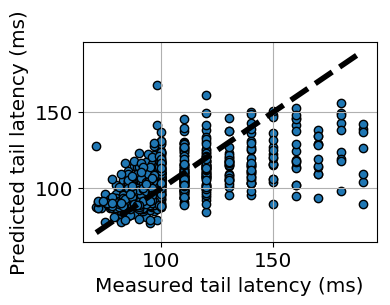

((1216, 56), (1216,))
((851, 56), (851,))
((780, 56), (780,))
('rlasso ', [4.339376133235989, -0.6937011869551574, -88.28522970974932, -5.27687336346421e-06, 0.0, 0.0, -0.09807754978120872, -2.4788197785753514, 0.0, -9.612508302246121e-07, 5.557739813147403e-05, -4.753448620441224e-05, 6.371479453756531, -0.0, 3.060065956202343e-06, 0.0, 0.0, 0.0, 27.20848888230371, 0.0, 0.0, 0.0002807192609472401, 1.2268946615874765e-05, 2.198225427933477, -9.024394191021448, -1.6188751547815564e-06, 0.0, 0.0, 0.751561706962174, 7.8354452953671805, 0.0, 1.1685306927240592e-05, 6.617890333938664e-05, 2.8496152983214326e-05, -1.1351212689465502, 0.0, 4.781139123273546e-06, 0.0, 0.0, 0.0, -0.3680129669668667, 0.0, 0.0, -4.9949799724537195e-05, -0.00039460666758491897, 0.0, -0.0, 4.961798503936681e-05, 0.0, 0.0, -0.6786707386243713, -2.0918000934232452, 0.0, 0.0, 2.0804708788199044e-08, 2.959754866299595e-08])
('rlasso ', 270.776985043313)
('feature selection length is ', 15, ['thread', 'cart_vm_util', 'c

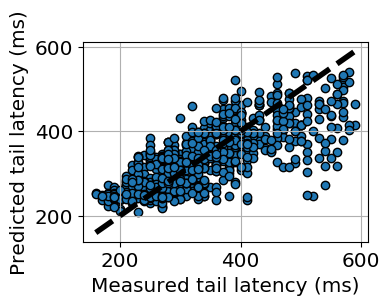

((1216, 45), (1216,))
((851, 45), (851,))
((815, 45), (815,))
('rlasso ', [2.188699831994133, -9.626611114062813, -0.0, 6.106660764673573e-05, 0.0, 0.0, 0.0, -0.0, 2.8224745416140057e-05, 4.510714078978884e-06, 1.3243026462479176e-05, -8.236873913181892e-06, 0.22650197449682347, 0.0, -7.817856081041577e-07, 0.0, 0.0, 1.6412289660099575, -1.6303413881498938, 0.0, -9.057746337549533e-07, 2.4135083434636545e-05, 2.546662498089161e-05, 1.7759292089423664, 52.16991046723997, -2.2035114516841904e-07, 0.0, 0.0, -0.051955099405032575, 9.739193897024922, 0.0, 0.0, -9.942276995946913e-05, -2.1509469860568808e-05, 2.340271106035568, -60.961512881337065, 1.753509633300239e-05, 0.0, 0.0, -1.266677615613859, 1.2228275262885648, 0.0, 0.0, -8.42095852545181e-08, 6.329274301146601e-08])
('rlasso ', 6.816422831803862)
('feature selection length is ', 13, ['thread', 'mongodb_vm_util', 'payment_vm_util', 'payment_workload', 'payment_cont_cpu5s_avg', 'user_vm_util', 'user_perf_cpi', 'user_workload', 'user_

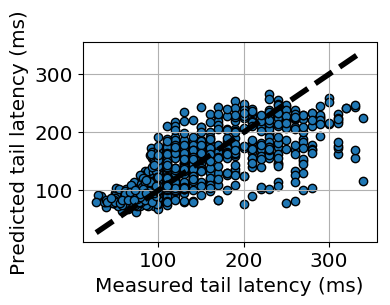

((1216, 45), (1216,))
((851, 45), (851,))
((734, 45), (734,))
('rlasso ', [6.708539412204132, 0.709588798099514, 0.0, -1.0901070168100458e-06, 0.0, 0.0, -0.01256562009889489, 28.049210762895022, 0.0, -3.336517104691341e-07, -0.00019032284210276953, -3.251504779531669e-05, -7.398779456278778, -155.49993683353816, 3.792991519943719e-05, 0.0, 0.0, 0.0, 9.08663357648878, -4.869537986122304e-06, 0.0, -4.964675974243563e-07, -8.868957166854084e-06, -3.1775980960043184, -0.0, 9.101974928877891e-06, 0.0, 0.0, 2.1115090294770673, 3.220785312705712, -2.7660902277208964e-05, 7.473248396895352e-06, -5.740258888911781e-07, 1.0064485424483948e-06, 6.025690592758811, 0.0, -1.8197265194302833e-05, 0.0, 0.0, -2.824103827263361, 0.5341756523969746, 0.0, 0.0, -5.365601920493901e-08, -3.758064722460477e-08])
('rlasso ', 165.5010670819731)
('feature selection length is ', 12, ['thread', 'cart_vm_util', 'cart_cont_cpu5s_avg', 'mysql_vm_util', 'mysql_perf_cpi', 'mysql_cont_cpu5s_avg', 'shipping_vm_util', 'sh

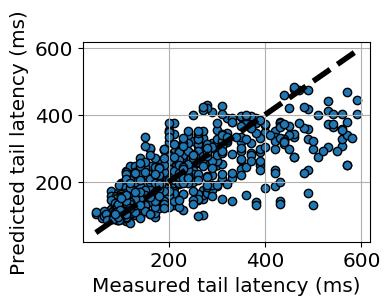

((1216, 45), (1216,))
((851, 45), (851,))
((794, 45), (794,))
('rlasso ', [-0.65917937428797, 1.4645426560843584, -0.0, -2.73596074593163e-06, 0.0, 0.0, 0.48529529306509217, 8.635198281732535, 0.0, -0.00358508914816426, -5.150014681955896e-05, -3.519508850050114e-06, 0.007147058086633329, -0.0, -6.725303281159377e-06, 0.0, 0.0, 0.0, 3.8766841897418045, -4.409704623681724e-06, 0.0, -1.726008713125997e-07, -2.8265245596214018e-05, -2.6654176924311157, 0.0, -1.1065683331835579e-05, 0.0, 0.0, 0.7193215703297453, -15.699255166689513, 0.0, 0.0, 4.0587945521608514e-05, -9.203582502747602e-06, 6.117500478950572, 0.0, -6.543122664350844e-06, 0.0, 0.0, -0.5453917647823179, 1.211572809267562, 0.0, 0.0, -2.1155835185073137e-08, -1.2988142715716342e-08])
('rlasso ', 198.3457466648827)
('feature selection length is ', 11, ['thread', 'catalogue_vm_util', 'catalogue_workload', 'catalogue_cont_cpu5s_avg', 'mysql_cont_cpu5s_avg', 'ratings_vm_util', 'ratings_workload', 'ratings_cont_cpu5s_avg', 'web_vm_u

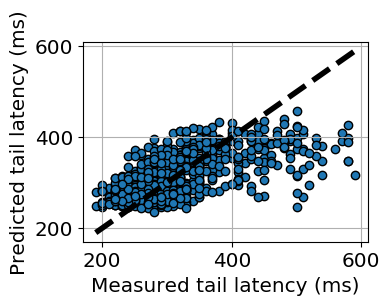

((1216, 56), (1216,))
((851, 56), (851,))
((812, 56), (812,))
('rlasso ', [0.8461754393954943, 0.02785179080519559, -0.0, 6.524400757731646e-06, 0.0, 0.0, 0.09631295467631248, 13.575073115998038, 0.0, 2.7750903846522295e-07, -3.000379281950987e-05, -1.809663843440708e-05, 0.6041337562946911, -0.0, -3.605557581438074e-06, 0.0, 0.0, 0.7683463655524568, -0.5496152392170923, 0.0, 1.14422835932084e-06, -1.2308030318752214e-06, -5.580961650338976e-06, 0.5639401178994141, -0.0, 3.891611939561995e-05, 0.0, 0.0, 0.0, 0.0, 6.982892167765784e-05, 0.0, 9.323189434783403e-05, -4.437763738992566e-06, 0.562174790989843, -0.0, -8.588216277740119e-06, 0.0, 0.0, 0.12491102777804051, 0.18962928119277364, 2.4429817711483282e-05, 6.748880913415556e-07, -2.2078888764000104e-07, 3.9530936373089587e-07, 4.41701587546877, -0.0, -1.3783420062443937e-05, 0.0, 0.0, -0.9866358098720746, 0.07868770407525197, 0.0, 0.0, -7.850384399563633e-08, 3.772828465068306e-08])
('rlasso ', 81.46798875704005)
('feature selection

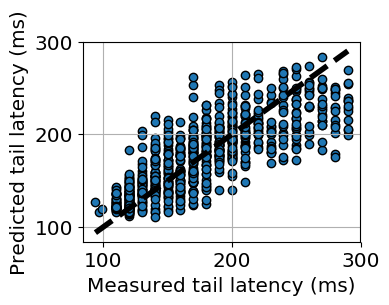

In [243]:


alpha_list = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
print(rdf_all.shape)

pod_list = ["ratings", "cart",  "user","payment", "catalogue", "shipping", "web", "mysql","mongodb",
            "dispatch", "redis","rabbitmq",]

predict_list_y = ["catalogue_95th_latency","payment_95th_latency", "user_95th_latency","shipping_95th_latency", 
                  "ratings_95th_latency", "cart_95th_latency",]


no_metrics = []
for name in ["_workload_fail"]:
    no_metrics += [ pod + name for pod in pod_list] 

workflow_pod = [["catalogue", "mongodb", "web", "ratings"],
    ["web", "payment", "dispatch", "cart", "rabbitmq"],
    ["web", "payment", "user", "mongodb", ],
    ["web", "cart", "mysql", "shipping"],
    ["catalogue", "mysql", "web", "ratings"],
    ["web", "payment", "cart", "redis", "shipping"]]




def filter_new(rdf, workflow):
    columns = rdf.columns.tolist()
    ret = ["thread"]
    
    for col in columns:
        pod = col.split("_")[0]
        if pod in workflow:
            ret.append(col)    
    return rdf[ret]
    
for i, workflow in enumerate(predict_list_y):
    #print("training ", locals()[y])
    # outlier filter
    name = workflow.split("_")[0]
    

    
    X1 = rdf_all.drop(latency_metrics+no_metrics, axis=1)
    
    X1 = filter_new(X1, workflow_pod[i])
    
    
    y = rdf_all[workflow]

    X = X1
    X, y = OutLierRemove(X, y)

    X = X[FeatureSelection(X, y, name,)]
    # filter some bad y value
    X = X[y>0]
    y = y[y>0]

    

    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    

    TrainingByDifferentModel(X, y, name)
    
    joblib.dump(scaler, 'models/scaler_{}.sav'.format(name))

In [456]:
from scipy.optimize import minimize, shgo
from scipy.optimize import Bounds
from scipy.optimize import BFGS
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
import joblib
import numpy as np
import time

slo_target_list = {
    'user' : 300,
    'cart' : 300,
    'catalogue' : 200,
    'payment' : 501,
    'ratings' : 500,
    'shipping': 450,
}

def load_models():
    models = {}
    for name in ['ratings', 'cart', 'catalogue', 'payment','user', 'shipping']:
        models[name] = {}
        models[name]['model'] = joblib.load('../ML/models/gp_{}.model'.format(name))
        models[name]['scaler'] = joblib.load('../ML/models/scaler_{}.sav'.format(name))
        models[name]['selected_feature'] = [line.strip() for line in open("../ML/models/selected_feature_{}.txt".format(name), 'r')]
        cpu_loc = []
        for i, feature in enumerate(models[name]['selected_feature']):
            if 'cpu5s' in feature or 'netR5s' in feature or 'netW5s' in feature:
                cpu_loc.append(i)
        models[name]['cpu_loc'] = cpu_loc
    return models


def optimize(model, data, workflow):
    
    #print(data)vm_util
    model_gp = model['model']
    selected_feature = model['selected_feature']
    scaler = model['scaler']
    
    cpu_loc = model['cpu_loc'] 
    slo_target = slo_target_list[workflow] 
    
    ### initialize data
    X = data[selected_feature]
    print(cpu_loc)
    #normalized values
    norm_temp = scaler.transform(X)[0]

    length = len(norm_temp)
    print(scaler.mean_, scaler.var_)
    
    y_pred, sigma = model_gp.predict(norm_temp.reshape(1, length), return_std=True)
    print("response time= {} stdev= {} target={}".format(y_pred,  sigma, slo_target))
    
    #if -1.0*(y_pred+2*sigma)+slo_target > 0:
    #    return 
        
    original_total_cpu = sum([norm_temp[loc] for loc in cpu_loc])
    
    def cpusum(x):
        """sum of normalized cpu utilization of various microservices"""
        #print(x)
        return 1*sum(x)

    def cons_f(x):
        temp = update_data(norm_temp, x)
        #temp = np.concatenate(( x, norm_vm, norm_workload), axis=None).reshape(1,length)
        y_pred, sigma = model_gp.predict(temp, return_std=True)
        #print("response time= {} stdev= {} target={}, {}".format(y_pred,  sigma, slo_target, slo_target-1.0*(y_pred+2*sigma)))

        return slo_target-1.0*(y_pred+2*sigma)

    
    def update_data(ret, update_list):
        length = len(ret)
        temp = ret.copy()
        for val in update_list:
            temp[cpu_loc] = val
        return np.array(temp).reshape(1, length)
    
    bounds = [ (norm_temp[loc],norm_temp[loc] + 2 ) for loc in cpu_loc ] 
    print(bounds)
    #[(-1.0,1.0)]*len(cpu_loc)
    #bounds = [(-1,1)]*len(cpu_loc)
    
    cons = ({'type': 'ineq', 'fun': cons_f})
    res = shgo(cpusum, bounds, iters=4, constraints=cons)
    print(res.x, cpusum(res.x))

    temp = update_data(norm_temp, res.x)
    #print(temp, norm_temp)
    y_pred, sigma = model_gp.predict(temp, return_std=True)
    print("response time= {} stdev= {} target={}".format(y_pred,  sigma, slo_target))

    
    final_result = scaler.inverse_transform(temp)[0]
    new_cputhresholds = [final_result[loc] for loc in cpu_loc]
    old_cputhresholds = [np.array(X)[0][loc] for loc in cpu_loc]
    print ("New denormalized cpu utilization % thresholds=", new_cputhresholds)
    #print ("sum of denormalized cpu utilization % =", sum(new_cputhresholds))
    print("original cpu utilization % cpu = ", old_cputhresholds)
    print("rate of new cpu and old cpu = ", [new_cputhresholds[i]/old_cputhresholds[i] for i in range(len(cpu_loc))])
    print ("\n")

    
    


In [457]:
models = load_models()    

def test(number):
    for key in sorted(models.keys()):
        value = rdf_all[number:number+1]
        print("{} {}".format(key, value[key+"_95th_latency"]))
        optimize(models[key], value, key)
    print("\n\n")
    
test(1)

cart 1    120.0
Name: cart_95th_latency, dtype: float64
[2, 5, 9, 12]
(array([ 24.72906404, 264.49753695,   2.56993778,   3.56302993,
       128.22660099,   3.24983549,   1.70711798,   2.9678639 ,
       128.41995074,  31.88560291,   4.94967482, 132.28817734,
        12.61591788]), array([1.28128564e+02, 1.22455259e+04, 1.65777494e+00, 1.40502958e+01,
       3.06381811e+03, 5.64189227e+00, 1.08717151e-01, 2.85829603e+00,
       3.07181995e+03, 2.31225160e+02, 2.37580308e+00, 3.06187508e+03,
       2.93852412e+01]))
response time= [144.79830706] stdev= [33.50482913] target=300
[(-1.4186040282182686, 0.5813959717817314), (-1.1480389744777546, 0.8519610255222454), (-1.4970734917489468, 0.5029265082510532), (-1.2483770584192682, 0.7516229415807318)]
(array([-1.41860403, -1.14803897, -1.49707349, -1.24837706]), -5.312093552864238)
response time= [146.66284666] stdev= [33.40332877] target=300
('New denormalized cpu utilization % thresholds=', [0.9625947704490858, 0.2846069367529447, 12.90266